In [7]:
# %%
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.ndimage import label, sum as nd_sum
from scipy.ndimage import zoom
import tifffile
import openslide
from PIL import Image

TRAIN_SLIDES_PARTICIPANT = '../experimentData/trainSlidesCorrectDaignosis.csv'
GAZE_MASK_PATH = '/fs/ess/PAS1575/Dataset/new_data/fixation_masks/fixation_reduction/'
GT_MASK_PATH = '/fs/ess/PAS1575/Dataset/CAMELYON16/training_masks/'

weight_threshold = '0.1'  # gaze weight threshold
default_size_threshold = 10  # Minimum size of regions to keep for expanded mask

In [2]:
### get train tumor slides
df_slides = pd.read_csv(TRAIN_SLIDES_PARTICIPANT)
df_slides = df_slides[df_slides['diagnosis']!='Benign']
masks = []
for i, row in df_slides.iterrows():
    masks.append(['_'.join([row['imageID'],row['pID'],weight_threshold])+'.npy', 
                  row['imageName'],
                  row['ratio'],])

print(len(masks))
print(masks[0])

81
['C77_P1_0.1.npy', 'tumor_001', 0.001857748]


In [3]:
### ground truth mask
def get_gt_mask(slide_name):
    gt_path = GT_MASK_PATH + f'{slide_name}_mask.tif'
    gt_mask = tifffile.imread(gt_path)
    gt_mask = zoom(gt_mask, zoom=1/224, order=0)  # Nearest-neighbor interpolation (order=0)
    slide_width = gt_mask.shape[1]
    slide_height = gt_mask.shape[0]
    gt_mask = gt_mask>0
    # print(f'gt_mask shape: {gt_mask.shape}')
    return gt_mask, np.sum(gt_mask), slide_width, slide_height

### pfmap mask
def get_gaze_mask(gaze_mask_name):
    pfmap_path = GAZE_MASK_PATH + gaze_mask_name
    pfmap_mask = np.load(pfmap_path)
    new_h, new_w = pfmap_mask.shape[0]/(224/32), pfmap_mask.shape[1]/(224/32)
    mask_img = Image.fromarray(pfmap_mask)
    gaze_mask = mask_img.resize((int(new_w), int(new_h)))
    gaze_mask = np.array(gaze_mask)
    # print(f'pfmap_mask shape: {gaze_mask.shape}')
    return gaze_mask, np.sum(gaze_mask)

### expanded mask
def get_expanded_mask(slide_name, slide_width, slide_height):
    df = pd.read_csv(f'tile_pred_results/{slide_name}.csv')
    min_x = df['x'].min()
    min_y = df['y'].min()
    max_x = df['x'].max()
    max_y = df['y'].max()
    mask = np.zeros((slide_height, slide_width), dtype=np.float32)
    for _, row in df.iterrows():
        x, y, yhat = int(row['x']), int(row['y']), row['yhat']
        mask[y, x] = yhat  # y is row index, x is column index
    binary_mask = (mask > 0.5).astype(int)
    # Label connected components in the binary mask
    labeled_mask, num_features = label(binary_mask)
    # Calculate the size of each component
    component_sizes = nd_sum(binary_mask, labeled_mask, index=np.arange(1, num_features + 1))
    largest_size = component_sizes.max()
    # Filter out small components
    cleaned_binary_mask = binary_mask.copy()
    # Minimum size of regions to keep
    size_threshold = min(default_size_threshold,largest_size) 
    for i, size in enumerate(component_sizes):
        if size < size_threshold:
            # Set small components to 0 in the labeled mask
            cleaned_binary_mask[labeled_mask == (i + 1)] = 0
    # print(f'expanded_mask shape: {cleaned_binary_mask.shape}')
    return cleaned_binary_mask, np.sum(cleaned_binary_mask)

In [8]:
def calculate_precision_recall(gt_mask, pred_mask):
    # Determine the smaller dimensions
    min_height = min(gt_mask.shape[0], pred_mask.shape[0])
    min_width = min(gt_mask.shape[1], pred_mask.shape[1])
    
    # Crop both masks to the smaller dimensions
    gt_mask_cropped = gt_mask[:min_height, :min_width]
    pred_mask_cropped = pred_mask[:min_height, :min_width]
    
    # True positives (TP): Tumor in both gt_mask and pred_mask
    TP = np.sum((gt_mask_cropped == 1) & (pred_mask_cropped == 1))
    
    # False positives (FP): Tumor in pred_mask but not in gt_mask
    FP = np.sum((gt_mask_cropped == 0) & (pred_mask_cropped == 1))
    
    # False negatives (FN): Tumor in gt_mask but not in pred_mask
    FN = np.sum((gt_mask_cropped == 1) & (pred_mask_cropped == 0))
    
    # Precision: TP / (TP + FP)
    precision = TP / (TP + FP) if (TP + FP) > 0 else 0
    
    # Recall: TP / (TP + FN)
    recall = TP / (TP + FN) if (TP + FN) > 0 else 0
    
    return precision, recall

In [ ]:
results = []
for i, mask in enumerate(masks):
    slide_name = mask[1]
    gaze_mask_name = mask[0]
    tumor_ratio = mask[2]
    print(f'{i}, slide_name: {slide_name}, tumor_ratio: {tumor_ratio}')

    res = {}
    res['slide_name'] = slide_name
    res['tumor_ratio'] = tumor_ratio

    gt_mask, size_gt_mask, slide_width, slide_height = get_gt_mask(slide_name)
    gaze_mask, size_gaze_mask = get_gaze_mask(gaze_mask_name)
    expanded_mask, size_expanded_mask = get_expanded_mask(slide_name, slide_width, slide_height)

    res['gt_size'] = size_gt_mask
    res['gaze_size'] = size_gaze_mask
    res['expanded_size'] = size_expanded_mask

    precision, recall = calculate_precision_recall(gt_mask, gaze_mask)
    res['gaze_precision'] = precision
    res['gaze_recall'] = recall

    precision, recall = calculate_precision_recall(gt_mask, expanded_mask)
    res['expanded_precision'] = precision
    res['expanded_recall'] = recall

    results.append(res)
    print(res)

df_results = pd.DataFrame(results)
df_results.to_csv('./results/mask_comparison_stats.csv', index=False)


In [57]:
# calculate mean precision and recall for gaze and expanded masks
df_results = pd.read_csv('./results/mask_comparison_stats.csv')

mean_gaze_precision = df_results['gaze_precision'].mean()
mean_gaze_recall = df_results['gaze_recall'].mean()
mean_expanded_precision = df_results['expanded_precision'].mean()
mean_expanded_recall = df_results['expanded_recall'].mean()
print(f'Mean PFMap Mask Precision: {mean_gaze_precision: 0.2f}')
print(f'Mean PFMap Mask Recall: {mean_gaze_recall: 0.2f}')
print(f'Mean Expanded Mask Precision: {mean_expanded_precision: 0.2f}')
print(f'Mean Expanded Mask Recall: {mean_expanded_recall: 0.2f}')

Mean PFMap Mask Precision:  0.41
Mean PFMap Mask Recall:  0.24
Mean Expanded Mask Precision:  0.56
Mean Expanded Mask Recall:  0.68


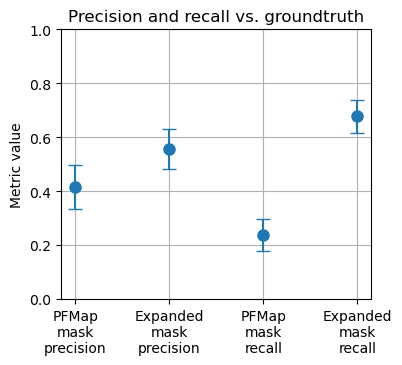

In [58]:
# plot precision and recall for gaze and expanded masks as dot plots with confidence intervals
import scipy.stats as stats

gaze_precision_ci = stats.t.interval(0.95, len(df_results['gaze_precision'])-1, loc=mean_gaze_precision, scale=stats.sem(df_results['gaze_precision']))
gaze_recall_ci = stats.t.interval(0.95, len(df_results['gaze_recall'])-1, loc=mean_gaze_recall, scale=stats.sem(df_results['gaze_recall']))
expanded_precision_ci = stats.t.interval(0.95, len(df_results['expanded_precision'])-1, loc=mean_expanded_precision, scale=stats.sem(df_results['expanded_precision']))
expanded_recall_ci = stats.t.interval(0.95, len(df_results['expanded_recall'])-1, loc=mean_expanded_recall, scale=stats.sem(df_results['expanded_recall']))

# plot
plt.figure(figsize=(4, 3.5))
plt.errorbar(['PFMap\nmask\nprecision', 'Expanded\nmask\nprecision', 'PFMap\nmask\nrecall', 'Expanded\nmask\nrecall'], 
             [mean_gaze_precision, mean_expanded_precision, mean_gaze_recall, mean_expanded_recall], 
             yerr=[[mean_gaze_precision-gaze_precision_ci[0], mean_expanded_precision-expanded_precision_ci[0], 
                    mean_gaze_recall-gaze_recall_ci[0], mean_expanded_recall-expanded_recall_ci[0]]], 
             fmt='o', capsize=5, markersize=8)
plt.title('Precision and recall vs. groundtruth')
plt.ylabel('Metric value')
plt.ylim(0, 1)
plt.grid()
plt.savefig('./results/mask_comparison_precision_recall.png', dpi=300, bbox_inches='tight')


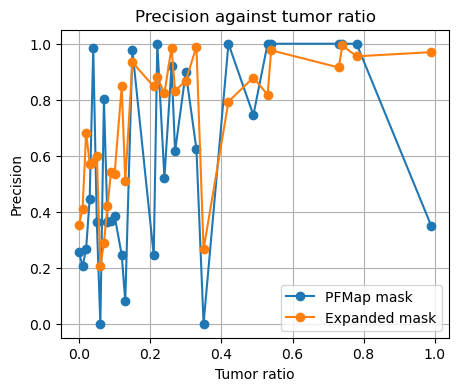

In [59]:
# make a line plot of precision for gaze and expanded masks using tumor ratio as x-axis

# sort df_results by tumor ratio
df_results_sort = df_results.sort_values(by='tumor_ratio')

# change tumor_ratio that is > 1 to 0.99
df_results_sort['tumor_ratio'] = df_results_sort['tumor_ratio'].apply(lambda x: 0.99 if x > 1 else x)

# combine results into 0.01 intervals
df_results_sort['tumor_ratio'] = df_results_sort['tumor_ratio'].apply(lambda x: round(x, 2))
df_results_sort = df_results_sort.groupby('tumor_ratio').mean().reset_index()

plt.figure(figsize=(5, 4))
plt.plot(df_results_sort['tumor_ratio'], df_results_sort['gaze_precision'], 'o-', label='PFMap mask')
plt.plot(df_results_sort['tumor_ratio'], df_results_sort['expanded_precision'], 'o-', label='Expanded mask')
plt.title('Precision against tumor ratio')
plt.xlabel('Tumor ratio')
plt.ylabel('Precision')
plt.legend()
plt.grid()
plt.savefig('./results/mask_comparison_precision_tumor_ratio.png', dpi=300, bbox_inches='tight')


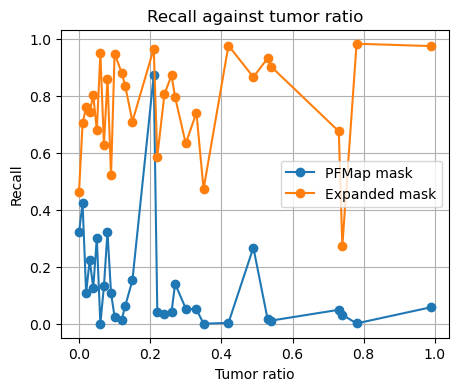

In [60]:
# make a line plot of recall for gaze and expanded masks using tumor ratio as x-axis

# sort df_results by tumor ratio
df_results_sort = df_results.sort_values(by='tumor_ratio')

# change tumor_ratio that is > 1 to 0.99
df_results_sort['tumor_ratio'] = df_results_sort['tumor_ratio'].apply(lambda x: 0.99 if x > 1 else x)

# combine results into 0.01 intervals
df_results_sort['tumor_ratio'] = df_results_sort['tumor_ratio'].apply(lambda x: round(x, 2))
df_results_sort = df_results_sort.groupby('tumor_ratio').mean().reset_index()

plt.figure(figsize=(5, 4))
plt.plot(df_results_sort['tumor_ratio'], df_results_sort['gaze_recall'], 'o-', label='PFMap mask')
plt.plot(df_results_sort['tumor_ratio'], df_results_sort['expanded_recall'], 'o-', label='Expanded mask')
plt.title('Recall against tumor ratio')
plt.xlabel('Tumor ratio')
plt.ylabel('Recall')
plt.legend()
plt.grid()
plt.savefig('./results/mask_comparison_recall_tumor_ratio.png', dpi=300, bbox_inches='tight')


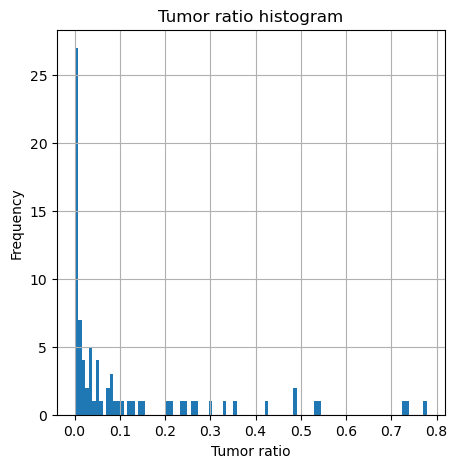

In [31]:
# make a tumor ratio histogram
plt.figure(figsize=(5, 5))
plt.hist(df_results[df_results['tumor_ratio']<1.0]['tumor_ratio'], bins=100)
plt.title('Tumor ratio histogram')
plt.xlabel('Tumor ratio')
plt.ylabel('Frequency')
plt.grid()